In [1]:
import warnings
warnings.filterwarnings('ignore')

import sentencepiece as spm
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
train_data = pd.read_table('data/ratings_train.txt')
test_data = pd.read_table('data/ratings_test.txt')
train_len = len(train_data)
total_data = pd.concat([train_data, test_data], axis=0)

# 한글과 공백을 제외한 나머지 삭제
total_data['document'] = total_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "")
print(len(total_data), train_len, len(test_data))

# 내용이 중복되거나 NaN값이 있는 열 삭제
total_data.drop_duplicates(subset=['document'], inplace=True)
total_data['document'] = total_data['document'].replace('', np.nan)
total_data = total_data.dropna(how = 'any')
print(len(total_data))

total_data.head()

200000 150000 50000
191073


,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


문장의 최단 길이: 1
문장의 최장 길이: 140
문장의 평균 길이: 33


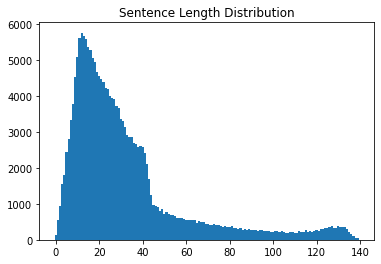

In [3]:
# 데이터 분석

min_len = 999
max_len = 0
sum_len = 0

raw = total_data['document']

for sen in raw:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(raw))

sentence_length = np.zeros((max_len), dtype=int)

for sen in raw:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [4]:
# 데이터 파악

def check_sentence_with_length(raw, length, num):
    count = 0 
    for sen in raw:
        if len(sen) == length:
            if count < num:
                print(sen, end=' / ')
            count += 1
    print('count', count)
    print('---------------------------------------------------')
check_sentence_with_length(raw, 0, 100)
check_sentence_with_length(raw, 1, 100)
check_sentence_with_length(raw, 2, 100)
check_sentence_with_length(raw, 3, 100)
check_sentence_with_length(raw, 60, 10)
check_sentence_with_length(raw, 140, 10)

count 0
---------------------------------------------------
아 / 점 / 잼 / 즐 / 끙 / 와 / 굿 /   / 기 / 짱 / 휴 / 야 / 음 / ㅎ / ㅋ / 굳 / 하 / 네 / ㅇ / 등 / ㅠ / 우 / 쒯 / 쩝 / 토 / 똥 / 흠 / 류 / 헐 / 삼 / 꽝 / 풉 / ㅅ / 왜 / ㄴ / 쉣 / 좇 / 봐 / 까 / 뿌 / ㅜ / 자 / 참 / ㅁ / ㅉ / 흥 / 찜 / 귯 / 린 / 후 / 시 / ㅗ / 웅 / ㅣ / 오 / 쩜 / 허 / 뀼 / 넌 / 빠 / 애 / 헝 / 쨩 / 움 / 켁 / 엥 / ㄳ / 업 / 헉 / 군 / 올 / 걍 / 뷁 / 좀 / 멍 / 쀍 / 뭐 / 로 / ㄹ / ㅂ / 갑 / 욱 / 즛 / 킥 / 함 / 진 / 읭 / ㅡ / 잠 / 풋 / 곧 / ㅍ / ㅏ / 엄 / 닥 / 꽤 / 캬 / ㅆ / ㄵ / ㄱ / count 130
---------------------------------------------------
최고 / 졸작 / 대박 / 버려 / 망함 / 굳굳 / 안습 / 대강 / 망작 / ㅇㅇ / 쵝오 / 별루 / 씐나 / 아오 / 글쎄 / 어휴 / 쓰렉 / 짱짱 / 웃스 / 좋다 / 볼만 / 허접 / 비추 / ㅎㅎ / 아나 / 아휴 / 빠닼 / 읭응 / ㅉㅉ / 역시 / 만세 / 야동 / 에휴 / 아하 / 별로 / 오오 /    / 에혀 / 평이 / 지루 / 별개 / 오욈 / ㅋㅋ / 지송 / 하네 / 눈물 / ㅅ바 / 와우 / 휴우 / 쯧쯧 / 당연 / 쩔어 / 별노 / 몰입 / 졸잼 / 씨발 / 구림 / 오짱 / 젠장 / 순수 / 돋네 / 오글 / 이응 / 참나 / 좋군 / 코콩 / 멋져 / 첨봄 / 최악 / 잼씀 / 유후 / 달달 / 감동 / 뭘까 / 광구 / 으리 / 글자 / 조앙 / 잤다 / 표절 / 명작 / 으휴 / 뭘봐 / 에효 / 의리 / 아  / 재미 / 그닥 / ㄱ굿 / 굿잡 / 잼나 / ㅜㅜ / 꿀잼 / 우왕 / 거지 / 굿굿 

In [5]:
max_len = 40

# 후반부에 결론 짓는 문장들이 많기에 뒤에서 40글자로 자름
filtered_corpus = [s[-max_len:] if len(s) > max_len else s for s in raw ]

In [6]:
# SentencePiece 클래스 생성 
class SentencePiece:
    def __init__(self, vocab_size=8000):
        self.temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'
        self.vocab_size = vocab_size
    
    def train(self, raw, model_type='unigram'):
        with open(self.temp_file, 'w') as f:
            for row in filtered_corpus:
                f.write(str(row) + '\n')

        spm.SentencePieceTrainer.Train(
            f'--input={self.temp_file} --model_type={model_type} --model_prefix=sp_{model_type}_{self.vocab_size} --vocab_size={self.vocab_size}'    
        )

vocab_size=8000
model_type='unigram'
# sp_model = SentencePiece(vocab_size=vocab_size)
# sp_model.train(raw, model_type=model_type)
!ls -l sp*

-rw-r--r-- 1 root root 373426 Aug 16 08:37 sp_bpe_8000.model
-rw-r--r-- 1 root root 118631 Aug 16 08:37 sp_bpe_8000.vocab
-rw-r--r-- 1 root root 518766 Aug 16 08:38 sp_unigram_15000.model
-rw-r--r-- 1 root root 294332 Aug 16 08:38 sp_unigram_15000.vocab
-rw-r--r-- 1 root root 377753 Aug 16 08:36 sp_unigram_8000.model
-rw-r--r-- 1 root root 147144 Aug 16 08:36 sp_unigram_8000.vocab


In [7]:
# SentencePiece이 잘 학습되었는지 확인
sp_model_uni_8000 = spm.SentencePieceProcessor()
sp_model_uni_8000.Load(f'sp_{model_type}_{vocab_size}.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = sp_model_uni_8000.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(sp_model_uni_8000.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(sp_model_uni_8000.DecodeIds(tokensIDs))

[1505, 7, 399, 12, 1264, 7, 135, 11, 0]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다 ⁇ 


In [8]:
def sp_tokenize(s, corpus, model_name, padding='pre', max_len=40): 

    tensor = list()
    # 문장을 인코딩하여 저장
    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open(f'./{model_name}.vocab', 'r') as f:
        vocab = f.readlines()

    word_to_index = dict()
    index_to_word = dict()

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]
        word_to_index.update({word: idx})
        index_to_word.update({idx: word})
    
    # 맥스 길이 40에 맞게 패딩을 앞에 집어 넣음 padding=pre
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding=padding, maxlen=max_len)

    return tensor, word_to_index, index_to_word

In [9]:
tensor, word_to_index, index_to_word = sp_tokenize(sp_model_uni_8000, raw, f'sp_{model_type}_{vocab_size}', max_len=max_len)
print(tensor)
print(len(tensor))

[[   0    0    0 ... 1930   48 1345]
 [   0    0    0 ...   15  616  388]
 [   0    0    0 ... 5836 1594  280]
 ...
 [   0    0    0 ... 6444   84 2596]
 [   0    0    0 ...  288  624   30]
 [   0    0    0 ...    9  183 3442]]
191073


In [10]:
# tensor = tensor.reshape(tensor.shape[0], tensor.shape[1], 1)
print(tensor[1])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0 1490 4718
  157 1227   26  297  163  572  355 1257 4740   15  616  388]


In [11]:
# train val test 데이터 나누기
X_train, y_train = tensor[:160000], total_data['label'][:160000]
X_val, y_val = tensor[160000:-73], total_data['label'][160000:-73]
X_test, y_test = tensor[-73:], total_data['label'][-73:]
print('train', len(X_train), len(y_train))
print('val', len(X_val), len(y_val))
print('test', len(X_test), len(y_test))

train 160000 160000
val 31000 31000
test 73 73


In [12]:
# 모델을 함수로 작성
def sequential_model(vocab_size, max_len=40):
    model = tf.keras.Sequential()
    # model.add(tf.keras.layers.LSTM(8, input_shape=(max_len, 1), return_sequences=True))
    model.add(tf.keras.layers.Embedding(vocab_size, 1, input_shape=(max_len,)))
    model.add(tf.keras.layers.LSTM(8))
    model.add(tf.keras.layers.Dense(8, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

model_uni_8000 = sequential_model(8000)
model_uni_8000.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 1)             8000      
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 320       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 8,401
Trainable params: 8,401
Non-trainable params: 0
_________________________________________________________________


In [13]:
es = EarlyStopping(monitor='val_loss', patience=4, verbose=1)

epochs = 50

history_uni_8000 = model_uni_8000.fit(X_train,
                                      y_train,
                                      epochs=epochs,
                                      batch_size=256,
                                      validation_data=(X_val, y_val),
                                      callbacks=[es]
                                     )

Epoch 1/50
625/625 [==============================] - 7s 6ms/step - loss: 0.5139 - accuracy: 0.7457 - val_loss: 0.3796 - val_accuracy: 0.8363
Epoch 2/50
625/625 [==============================] - 3s 5ms/step - loss: 0.3447 - accuracy: 0.8536 - val_loss: 0.3591 - val_accuracy: 0.8437
Epoch 3/50
625/625 [==============================] - 3s 5ms/step - loss: 0.3270 - accuracy: 0.8613 - val_loss: 0.3567 - val_accuracy: 0.8464
Epoch 4/50
625/625 [==============================] - 3s 5ms/step - loss: 0.3202 - accuracy: 0.8642 - val_loss: 0.3560 - val_accuracy: 0.8460
Epoch 5/50
625/625 [==============================] - 3s 5ms/step - loss: 0.3177 - accuracy: 0.8653 - val_loss: 0.3571 - val_accuracy: 0.8463
Epoch 6/50
625/625 [==============================] - 3s 5ms/step - loss: 0.3161 - accuracy: 0.8657 - val_loss: 0.3568 - val_accuracy: 0.8459
Epoch 7/50
625/625 [==============================] - 3s 5ms/step - loss: 0.3148 - accuracy: 0.8666 - val_loss: 0.3585 - val_accuracy: 0.8464
Epoch 

In [14]:
# 테스트 값 결과 확인
results = model_uni_8000.evaluate(X_test, y_test, verbose=2)
print(results)

3/3 - 0s - loss: 0.3424 - accuracy: 0.7945
[0.3424074649810791, 0.7945205569267273]


In [15]:
vocab_size=8000
model_type='bpe'
# sp_model = SentencePiece(vocab_size=vocab_size)
# sp_model.train(raw, model_type=model_type)

sp_model_bpe_8000 = spm.SentencePieceProcessor()
sp_model_bpe_8000.Load(f'sp_{model_type}_{vocab_size}.model')

tensor, word_to_index, index_to_word = sp_tokenize(sp_model_bpe_8000, raw, f'sp_{model_type}_{vocab_size}', max_len=max_len)
print(tensor)

X_train, y_train = tensor[:160000], total_data['label'][:160000]
X_val, y_val = tensor[160000:-73], total_data['label'][160000:-73]
X_test, y_test = tensor[-73:], total_data['label'][-73:]
print('train', len(X_train), len(y_train))
print('val', len(X_val), len(y_val))
print('test', len(X_test), len(y_test))

model_bpe_8000 = sequential_model(vocab_size)
model_bpe_8000.summary()

[[   0    0    0 ... 2149   28 1943]
 [   0    0    0 ... 6436   63  360]
 [   0    0    0 ... 1248 1459  241]
 ...
 [   0    0    0 ... 6495  101 2954]
 [   0    0    0 ...  125 6700 6471]
 [   0    0    0 ...  301  244 3293]]
train 160000 160000
val 31000 31000
test 73 73
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 40, 1)             8000      
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 320       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 8,401
Trainable params: 8,401
Non-trainable params: 0
_________________________________________

In [16]:
history_bpe_8000 = model_bpe_8000.fit(X_train,
                                  y_train,
                                  epochs=epochs,
                                  batch_size=256,
                                  validation_data=(X_val, y_val),
                                  callbacks=[es]
                                 )

Epoch 1/50
625/625 [==============================] - 5s 5ms/step - loss: 0.4994 - accuracy: 0.7511 - val_loss: 0.3730 - val_accuracy: 0.8365
Epoch 2/50
625/625 [==============================] - 3s 5ms/step - loss: 0.3415 - accuracy: 0.8537 - val_loss: 0.3573 - val_accuracy: 0.8429
Epoch 3/50
625/625 [==============================] - 3s 5ms/step - loss: 0.3263 - accuracy: 0.8613 - val_loss: 0.3557 - val_accuracy: 0.8449
Epoch 4/50
625/625 [==============================] - 3s 5ms/step - loss: 0.3213 - accuracy: 0.8634 - val_loss: 0.3565 - val_accuracy: 0.8451
Epoch 5/50
625/625 [==============================] - 3s 5ms/step - loss: 0.3182 - accuracy: 0.8652 - val_loss: 0.3599 - val_accuracy: 0.8450
Epoch 6/50
625/625 [==============================] - 3s 5ms/step - loss: 0.3167 - accuracy: 0.8667 - val_loss: 0.3585 - val_accuracy: 0.8445
Epoch 7/50
625/625 [==============================] - 3s 5ms/step - loss: 0.3150 - accuracy: 0.8675 - val_loss: 0.3606 - val_accuracy: 0.8408
Epoch 

In [17]:
results = model_bpe_8000.evaluate(X_test, y_test, verbose=2)
print(results)

3/3 - 0s - loss: 0.3719 - accuracy: 0.8082
[0.3718911409378052, 0.8082191944122314]


In [18]:
vocab_size=15000
model_type='unigram'
# sp_model = SentencePiece(vocab_size=vocab_size)
# sp_model.train(raw, model_type=model_type)

sp_model_uni_15000 = spm.SentencePieceProcessor()
sp_model_uni_15000.Load(f'sp_{model_type}_{vocab_size}.model')

tensor, word_to_index, index_to_word = sp_tokenize(sp_model_uni_15000, raw, f'sp_{model_type}_{vocab_size}', max_len=max_len)
print(tensor)

X_train, y_train = tensor[:160000], total_data['label'][:160000]
X_val, y_val = tensor[160000:-73], total_data['label'][160000:-73]
X_test, y_test = tensor[-73:], total_data['label'][-73:]
print('train', len(X_train), len(y_train))
print('val', len(X_val), len(y_val))
print('test', len(X_test), len(y_test))

model_uni_15000 = sequential_model(vocab_size)
model_uni_15000.summary()

[[   0    0    0 ... 1907   60 1315]
 [   0    0    0 ... 9056  790  344]
 [   0    0    0 ...   10 1873  262]
 ...
 [   0    0    0 ... 6184  105 2147]
 [   0    0    0 ...  314  888   38]
 [   0    0    0 ...    9  143 2866]]
train 160000 160000
val 31000 31000
test 73 73
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 40, 1)             15000     
_________________________________________________________________
lstm_2 (LSTM)                (None, 8)                 320       
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 15,401
Trainable params: 15,401
Non-trainable params: 0
_______________________________________

In [19]:
history_uni_15000 = model_uni_15000.fit(X_train,
                                  y_train,
                                  epochs=epochs,
                                  batch_size=256,
                                  validation_data=(X_val, y_val),
                                  callbacks=[es]
                                 )

Epoch 1/50
625/625 [==============================] - 5s 5ms/step - loss: 0.5198 - accuracy: 0.7424 - val_loss: 0.3823 - val_accuracy: 0.8378
Epoch 2/50
625/625 [==============================] - 3s 5ms/step - loss: 0.3335 - accuracy: 0.8606 - val_loss: 0.3555 - val_accuracy: 0.8490
Epoch 3/50
625/625 [==============================] - 3s 5ms/step - loss: 0.3043 - accuracy: 0.8743 - val_loss: 0.3534 - val_accuracy: 0.8511
Epoch 4/50
625/625 [==============================] - 3s 5ms/step - loss: 0.2937 - accuracy: 0.8790 - val_loss: 0.3577 - val_accuracy: 0.8487
Epoch 5/50
625/625 [==============================] - 3s 5ms/step - loss: 0.2871 - accuracy: 0.8825 - val_loss: 0.3571 - val_accuracy: 0.8493
Epoch 6/50
625/625 [==============================] - 3s 5ms/step - loss: 0.2833 - accuracy: 0.8841 - val_loss: 0.3589 - val_accuracy: 0.8475
Epoch 7/50
625/625 [==============================] - 3s 5ms/step - loss: 0.2801 - accuracy: 0.8854 - val_loss: 0.3613 - val_accuracy: 0.8465
Epoch 

In [20]:
results = model_uni_15000.evaluate(X_test, y_test, verbose=2)
print(results)

3/3 - 0s - loss: 0.4339 - accuracy: 0.7945
[0.43388184905052185, 0.7945205569267273]


In [27]:
vocab_size = 15000
model_type = 'bpe'
# sp_model = SentencePiece(vocab_size=vocab_size)
# sp_model.train(raw, model_type=model_type)

sp_model_bpe_15000 = spm.SentencePieceProcessor()
sp_model_bpe_15000.Load(f'sp_{model_type}_{vocab_size}.model')

tensor, word_to_index, index_to_word = sp_tokenize(sp_model_bpe_15000, raw, f'sp_{model_type}_{vocab_size}', max_len=max_len)
print(tensor)

X_train, y_train = tensor[:160000], total_data['label'][:160000]
X_val, y_val = tensor[160000:-73], total_data['label'][160000:-73]
X_test, y_test = tensor[-73:], total_data['label'][-73:]
print('train', len(X_train), len(y_train))
print('val', len(X_val), len(y_val))
print('test', len(X_test), len(y_test))

model_bpe_15000 = sequential_model(vocab_size)
model_bpe_15000.summary()

[[    0     0     0 ...  2149    28  1943]
 [    0     0     0 ... 13436    63   360]
 [    0     0     0 ...  1248  1459   241]
 ...
 [    0     0     0 ...  6832   101  2954]
 [    0     0     0 ...   125 13700 13471]
 [    0     0     0 ...   301   244  3293]]
train 160000 160000
val 31000 31000
test 73 73
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 40, 1)             15000     
_________________________________________________________________
lstm_3 (LSTM)                (None, 8)                 320       
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 15,401
Trainable params: 15,401
Non-trainable params: 0
___

In [29]:
history_bpe_15000 = model_bpe_8000.fit(X_train,
                                       y_train,
                                       epochs=epochs,
                                       batch_size=256,
                                       validation_data=(X_val, y_val),
                                       callbacks=[es]
                                      )

Epoch 1/50
625/625 [==============================] - 3s 5ms/step - loss: 0.6883 - accuracy: 0.5693 - val_loss: 0.6390 - val_accuracy: 0.6370
Epoch 2/50
625/625 [==============================] - 3s 5ms/step - loss: 0.5465 - accuracy: 0.7191 - val_loss: 0.4795 - val_accuracy: 0.7705
Epoch 3/50
625/625 [==============================] - 3s 5ms/step - loss: 0.4309 - accuracy: 0.8011 - val_loss: 0.4186 - val_accuracy: 0.8090
Epoch 4/50
625/625 [==============================] - 3s 5ms/step - loss: 0.3827 - accuracy: 0.8287 - val_loss: 0.3950 - val_accuracy: 0.8207
Epoch 5/50
625/625 [==============================] - 3s 5ms/step - loss: 0.3603 - accuracy: 0.8412 - val_loss: 0.3870 - val_accuracy: 0.8247
Epoch 6/50
625/625 [==============================] - 3s 5ms/step - loss: 0.3483 - accuracy: 0.8471 - val_loss: 0.3794 - val_accuracy: 0.8286
Epoch 7/50
625/625 [==============================] - 3s 5ms/step - loss: 0.3409 - accuracy: 0.8513 - val_loss: 0.3790 - val_accuracy: 0.8303
Epoch 

In [30]:
results = model_bpe_15000.evaluate(X_test, y_test, verbose=2)
print(results)

3/3 - 1s - loss: 0.6931 - accuracy: 0.5068
[0.6930926442146301, 0.5068492889404297]


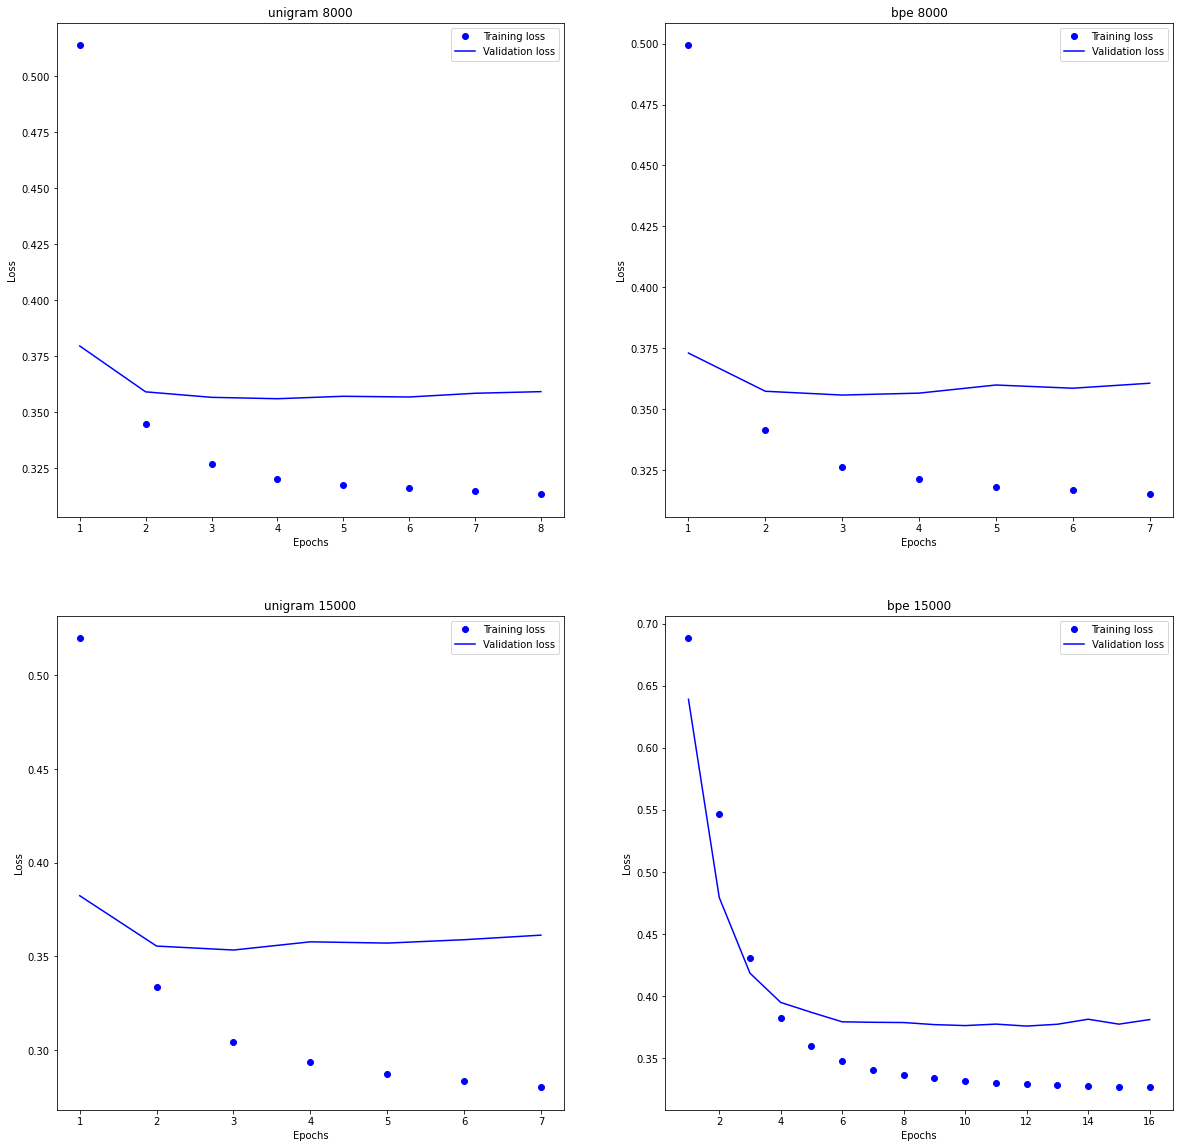

In [35]:
# 4개의 모델들의 학습 상태를 그래프로 표현

history_dict = history_uni_8000.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(20, 20))

plt.subplot(2, 2, 1)   
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('unigram 8000')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

history_dict = history_bpe_8000.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.subplot(2, 2, 2) 
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('bpe 8000')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


history_dict = history_uni_15000.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.subplot(2, 2, 3)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('unigram 15000')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


history_dict = history_bpe_15000.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.subplot(2, 2, 4)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('bpe 15000')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


plt.show()

# 각결과의 분석진행

sentencepiece를 총 4개의 model_type = unigram, bpe, vocab_size = 8000, 15000을 섞어서 모델을 작성함
각 모델은 정확도가 약 80% 전후로 나왔으나 bpe 15000 모델을 사용한 lstm만 테스트데이터가 50%가 나옴
lstm의 학습 과정들은 전부 정확도 약 85% 로스값 35%로 수렴함